<a href="https://colab.research.google.com/github/leojklarner/gauche/blob/main/notebooks/pretrained_graph_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Installation 

!git clone https://github.com/leojklarner/gauche.git
%cd gauche
!pip install rdkit

# !conda install pytorch torchvision torchaudio
# !pip install scikit-learn pandas pytest tqdm jupyter

!pip install gpytorch botorch selfies
!pip install graphein==1.4.0
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip uninstall matplotlib -y
!pip install matplotlib==3.1.3

     |████████████████████████████████| 7.9 MB 26.6 MB/s 
     |████████████████████████████████| 3.5 MB 27.2 MB/s 
Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Successfully uninstalled matplotlib-3.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 36.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
graphein 1.4.0 requires matplotlib>=3.4.3, but you have matplotlib 3.1.3 which is incompatible.


To do so, use the following command: pip install biovec
pytorch3d cannot be installed via pip
To do so, use the following command: pip install pytorch3d



Trial  1 of 20 

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


....................
Trial  2 of 20 ....................
Trial  3 of 20 ....................
Trial  4 of 20 ....................
Trial  5 of 20 ....................
Trial  6 of 20 ....................
Trial  7 of 20 ....................
Trial  8 of 20 ....................
Trial  9 of 20 ....................
Trial 10 of 20 ....................
Trial 11 of 20 ....................
Trial 12 of 20 ....................
Trial 13 of 20 ....................
Trial 14 of 20 ....................
Trial 15 of 20 ....................
Trial 16 of 20 ....................
Trial 17 of 20 ....................
Trial 18 of 20 ....................
Trial 19 of 20 ....................
Trial 20 of 20 ....................

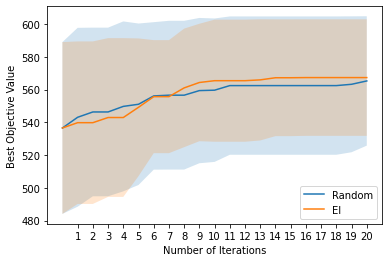

In [2]:
import sys, time, warnings, numpy as np, torch, random
sys.path.append('..')
from matplotlib import pyplot as plt
from rdkit.Chem import MolFromSmiles
from sklearn.model_selection import train_test_split

from botorch import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.models.gp_regression import SingleTaskGP

from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood

from gprotorch.dataloader import DataLoaderMP
from gprotorch.kernels.gnn_kernels.pretrained_kernel import GNN, mol_to_pyg

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)

# We define our custom GP surrogate model using the RBF kernel
class GP_PretrainedKernel(SingleTaskGP):

    def __init__(self, train_X, train_Y):
        super().__init__(train_X, train_Y, GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(base_kernel=RBFKernel())
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

"""We define helper functions for the Bayesian optimisation loop.
 In particular the acquisition function optimisation procedure
 is framed so as to take the maximum over a discrete 
 set of heldout molecules."""

def initialize_model(train_x, train_obj, state_dict=None):
    """
    Initialise model and loss function.
    Args:
        train_x: tensor of inputs
        train_obj: tensor of outputs
        state_dict: current state dict used to speed up fitting
    Returns: mll object, model object
    """

    # define model for objective
    model = GP_PretrainedKernel(train_x, train_obj).to(train_x)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)

    return mll, model


def optimize_acqf_and_get_observation(
    acq_func, heldout_inputs, heldout_outputs):
    """
    Optimizes the acquisition function, and returns a 
    new candidate and an observation.
    Args:
        acq_func: Object representing the acquisition function
        heldout_points: Tensor of heldout points
    Returns: new_x, new_obj
    """

    # Loop over the discrete set of points to evaluate 
    # the acquisition function at.
    acq_vals = []
    for i in range(len(heldout_outputs)):
        acq_vals.append(acq_func(heldout_inputs[i].unsqueeze(-2)))  
        # use unsqueeze to append batch dimension

    # observe new values
    acq_vals = torch.tensor(acq_vals)
    best_idx = torch.argmax(acq_vals)
    new_x = heldout_inputs[best_idx].unsqueeze(-2)  
    # add batch dimension
    new_obj = heldout_outputs[best_idx].unsqueeze(-1)  
    # add output dimension

    # Delete the selected input and value from the heldout set.
    heldout_inputs = torch.cat(
        (heldout_inputs[:best_idx], heldout_inputs[best_idx+1:]), axis=0)
    heldout_outputs = torch.cat(
        (heldout_outputs[:best_idx], heldout_outputs[best_idx+1:]), axis=0)

    return new_x, new_obj, heldout_inputs, heldout_outputs


def update_random_observations(
    best_random, heldout_inputs, heldout_outputs):
    """
    Simulates a random policy by taking a the current list of 
    best values observed randomly,
    drawing a new random point from the heldout set, observing its value,
    and updating the list.
    Args:
        best_random: List of best random values observed so far
        heldout_inputs: Tensor of inputs
        heldout_outputs: Tensor of output values
    Returns: best_random, float specifying the objective function value.
    """

    # Take a random sample by permuting the indices and selecting 
    # the first element.
    index = torch.randperm(len(heldout_outputs))[0]
    next_random_best = heldout_outputs[index]
    best_random.append(max(best_random[-1], next_random_best))

    # Delete the selected input and value from the heldout set.
    heldout_inputs = torch.cat(
        (heldout_inputs[:index], heldout_inputs[index+1:]), axis=0)
    heldout_outputs = torch.cat(
        (heldout_outputs[:index], heldout_outputs[index+1:]), axis=0)

    return best_random, heldout_inputs, heldout_outputs

"""Run the Bayesian optimisation loop, comparing the analytic 
(sequential) expected improvement acquisition funciton with 
a random policy."""

# Bayesian optimisation experiment parameters, number 
# of random trials, split size, batch size
# and number of iterations of Bayesian optimisation.

N_TRIALS = 20
holdout_set_size = 0.95
N_ITERS = 20
verbose = False
set_seed(12)

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

best_observed_all_ei, best_random_all = [], []

# Load the Photoswitch dataset
loader = DataLoaderMP()
loader.load_benchmark(
    "Photoswitch", "data/property_prediction/photoswitches.csv")

# We use the fragprints representations (a concatenation 
# of Morgan fingerprints and RDKit fragment features)
y = loader.labels

# get PyTorch Geometric featurisation of molecules
graphs = [
    mol_to_pyg(MolFromSmiles(smiles)) for smiles in loader.features
]

# load pretrained model
with torch.no_grad():
    model = GNN(gnn_type='gin')
    model.load_pretrained('contextpred', device=torch.device("cpu"))

    X = torch.stack(
        [
            model(
                x=graphs[i].x,
                edge_index=graphs[i].edge_index,
                edge_attr=graphs[i].edge_attr,
            ).mean(0) for i in range(len(graphs))
        ]
    )

# average over multiple random trials (each trial splits
# the initial training set for the GP in a random manner)
for trial in range(1, N_TRIALS + 1):

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei, best_random = [], []

    # Generate initial training data and initialize model
    train_x_ei, heldout_x_ei, train_y_ei, heldout_y_ei = train_test_split(
        X, y, test_size=holdout_set_size, random_state=trial)
    best_observed_value_ei = torch.tensor(np.max(train_y_ei))

    # Convert numpy arrays to PyTorch tensors and flatten the label vectors
    train_y_ei = torch.tensor(train_y_ei)
    heldout_y_ei = torch.tensor(heldout_y_ei)

    # The initial heldout set is the same for random search
    heldout_x_random = heldout_x_ei
    heldout_y_random = heldout_y_ei

    mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei)

    best_observed_ei.append(best_observed_value_ei)
    best_random.append(best_observed_value_ei)

    # run N_ITERS rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_ITERS + 1):

        t0 = time.time()

        # fit the model
        fit_gpytorch_model(mll_ei)

        # Use analytic acquisition function for batch size of 1.
        EI = ExpectedImprovement(model=model_ei, best_f=\
        (train_y_ei.to(train_y_ei)).max())

        new_x_ei, new_obj_ei, heldout_x_ei, heldout_y_ei =\
        optimize_acqf_and_get_observation(EI, heldout_x_ei, heldout_y_ei)

        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_y_ei = torch.cat([train_y_ei, new_obj_ei])

        # update random search progress
        best_random, heldout_x_random, heldout_y_random = \
        update_random_observations(best_random, 
                                   heldout_inputs=heldout_x_random,
                                   heldout_outputs=heldout_y_random)
        best_value_ei = torch.max(new_obj_ei, best_observed_ei[-1])
        best_observed_ei.append(best_value_ei)

        # reinitialise the model so it is ready for fitting on the next
        # iteration use the current state dict to speed up fitting
        mll_ei, model_ei = initialize_model(
            train_x_ei,
            train_y_ei,
            model_ei.state_dict(),
        )

        t1 = time.time()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}), "
                f"time = {t1 - t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")

    best_observed_all_ei.append(best_observed_ei)
    best_random_all.append(best_random)

# Define a confience interval function for plotting.
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

iters = np.arange(N_ITERS + 1)

y_ei = []
for i in range(len(best_observed_all_ei)):
    y_ei_inner = []
    for j in range(len(best_observed_all_ei[i])):
        y_ei_inner.append(best_observed_all_ei[i][j].item())
    y_ei.append(y_ei_inner)
y_ei = np.asarray(y_ei)

y_rnd = []
for i in range(len(best_random_all)):
    y_rnd_inner = []
    for j in range(len(best_random_all[i])):
        y_rnd_inner.append(best_random_all[i][j].item())
    y_rnd.append(y_rnd_inner)
y_rnd = np.asarray(y_rnd)

y_rnd_mean = y_rnd.mean(axis=0)
y_ei_mean = y_ei.mean(axis=0)
y_rnd_std = y_rnd.std(axis=0)
y_ei_std = y_ei.std(axis=0)

lower_rnd = y_rnd_mean - y_rnd_std
upper_rnd = y_rnd_mean + y_rnd_std
lower_ei = y_ei_mean - y_ei_std
upper_ei = y_ei_mean + y_ei_std

plt.plot(iters, y_rnd_mean, label='Random')
plt.fill_between(iters, lower_rnd, upper_rnd, alpha=0.2)
plt.plot(iters, y_ei_mean, label='EI')
plt.fill_between(iters, lower_ei, upper_ei, alpha=0.2)
plt.xlabel('Number of Iterations')
plt.ylabel('Best Objective Value')
plt.legend(loc="lower right")
plt.xticks(list(np.arange(1, 21)))
plt.show()

In [3]:
"""
EI outperforms random search in terms of selecting molecules with 
high E isomer pi-pi* transition wavelength! It should be noted that
the true objective for photoswitch optimisation would consider all 
transition wavelengths as well as the thermal half-life and this 
will hopefully be included in a future notebook!
"""

'\nEI outperforms random search in terms of selecting molecules with \nhigh E isomer pi-pi* transition wavelength! It should be noted that\nthe true objective for photoswitch optimisation would consider all \ntransition wavelengths as well as the thermal half-life and this \nwill hopefully be included in a future notebook!\n'